In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import itertools

**Overview of NDWI**

Normalized difference water index (NDWI) from McFEETERS 1996
* NDWI = (Green - NIR)/(Green + NIR)
    
Landsat 8 bands from USGS LPDAAC documentation: https://lpdaac.usgs.gov/products/hlsl30v002/
- Green = Band 3
- NIR = Band 5

**Data download steps**
1) Get shell script from NASA Earthdata interface. This is where you specify temporal and spatial bounds.
2) Run the shell script. Recommended to put the script in its own folder.
3) Remove unnecessary bands. I only need B3 and B5, so I use the command `rm !(*B03*|*B05*)`.
4) Run below gdal code from Alex Georges to combine files into one.

In [39]:
# Original code from Alex
# import os, glob
# from osgeo import gdal
# # Directory to find individual files
# dirpath = "/global/scratch/users/ann_scheliga/aux_dam_datasets/Landsat8/"
# search_criteria = '*.tif'
# # Output file path and name
# out_fp = "/global/scratch/users/ann_scheliga/aux_dam_datasets/Landsat8/test_mosaic.tif"
# # Query search
# q = os.path.join(dirpath, search_criteria)
# # Gets all the geotiff file paths inside the folder
# files_to_mosaic = glob.glob(q)
# # Function to Merge all files
# g = gdal.Warp(out_fp, files_to_mosaic, format='GTiff')
# # Flush the file to local and close it from memory
# g = None

In [56]:
def combine_landsat_geotiffs(date_code = '', band = '', output_fn = '', 
                         dir_path = "/global/scratch/users/ann_scheliga/aux_dam_datasets/Landsat8/"):
    # Input handling
    date_code = str(date_code)
    band = str(band)

    # Create a useful default name for the output file
    if not output_fn:
        output_fn = '_'.join(['landsat',date_code,band]) + '.tif'

    # Create regex for searching through files in directory
    search_criteria = '*' + date_code + '*' + band +'.tif'
    print('Searching by:',search_criteria)
    # Output file path and name
    out_fp = dir_path + output_fn
    # Query search
    q = os.path.join(dirpath, search_criteria)
    # Gets all the geotiff file paths inside the folder
    files_to_mosaic = glob.glob(q)
    # Function to Merge all files
    g = gdal.Warp(out_fp, files_to_mosaic, format='GTiff')
    # Flush the file to local and close it from memory
    g = None
    print('Created:', output_fn)

In [60]:
# Bands of interest to loop through
bands_oi = ['B03','B05']
# Date codes of interest to loop through (should convert to scraped later)
dates_oi = [2013103,2013105]

# Creates a list of all date-band combinations
criteria_list = list(itertools.product(dates_oi,bands_oi))

# Create a mosaic geotiff for each combo
for criteria in criteria_list:
    combine_landsat_geotiffs(*criteria)
# combine_landsat_geotiffs(2013103,'B05')

[('B03', 2013103), ('B03', 2013105), ('B05', 2013103), ('B05', 2013105)]

In [40]:
test_mosaic = rxr.open_rasterio(out_fp)
test_mosaic

<xarray.DataArray (band: 1, y: 10539, x: 8348)>
[87979572 values with dtype=int16]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 1.594e+05 1.594e+05 ... 4.097e+05 4.098e+05
  * y            (y) float64 4.304e+06 4.304e+06 ... 3.988e+06 3.988e+06
    spatial_ref  int64 0
Attributes: (12/36)
    ACCODE:                    *
    add_offset:                0.0
    AREA_OR_POINT:             Area
    arop_ave_xshift(meters):   *
    arop_ave_yshift(meters):   *
    arop_ncp:                  *
    ...                        ...
    TIRS_SSM_MODEL:            *
    TIRS_SSM_POSITION_STATUS:  *
    ULX:                       *
    ULY:                       *
    USGS_SOFTWARE:             LPGS_15.3.1c
    _FillValue:                -9999

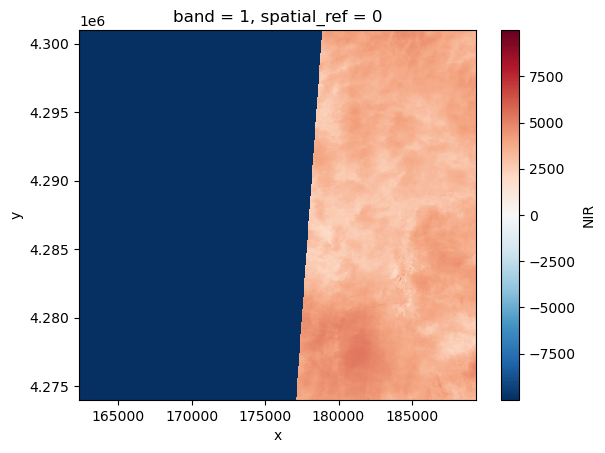

In [41]:
test_mosaic.isel(x=np.arange(100,1000),y=np.arange(100,1000)).plot()

## Edit USGS .sh download file

In [58]:
sh_fp = '/global/scratch/users/ann_scheliga/aux_dam_datasets/Landsat8/'
sh_fn = '3690478433-download.sh'
# sh_raw = pd.read_table('/global/scratch/users/ann_scheliga/aux_dam_datasets/Landsat8/3690478433-download.sh',header=None)

In [15]:
sh_raw.iloc[98:]

,0
98,https://data.lpdaac.earthdatacloud.nasa.gov/lp...
99,https://data.lpdaac.earthdatacloud.nasa.gov/lp...
100,https://data.lpdaac.earthdatacloud.nasa.gov/lp...
101,https://data.lpdaac.earthdatacloud.nasa.gov/lp...
102,https://data.lpdaac.earthdatacloud.nasa.gov/lp...
...,...
63079,https://data.lpdaac.earthdatacloud.nasa.gov/lp...
63080,https://data.lpdaac.earthdatacloud.nasa.gov/lp...
63081,https://data.lpdaac.earthdatacloud.nasa.gov/lp...
63082,https://data.lpdaac.earthdatacloud.nasa.gov/lp...


In [61]:
# Read the original file and create new shortened file

# Grab original content and make edits
with open(sh_fp+sh_fn,"r") as f:
    # Create a list of file contents (instead of a string)
    full_file = f.readlines()
    # Split content into sections
    front_matter = full_file[:97]
    urls = full_file[97:-1]
    back_matter = full_file[-1:]
    # Set filters for urls
    filter_strs = ['B03','B05','Fmask']
    # Select only urls that contain any filter value
    urls_shortened = [url for url in urls if any(band in url for band in filter_strs)]
    final_file = front_matter + urls_shortened + back_matter

# Write the editted script to a new file.
with open(sh_fp + 'download_script_B03_B05.sh',"w") as f:
    f.writelines(final_file)